In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import print_confusion_matrix, evaluate_model, plot_roc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from imblearn.over_sampling import SMOTE

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

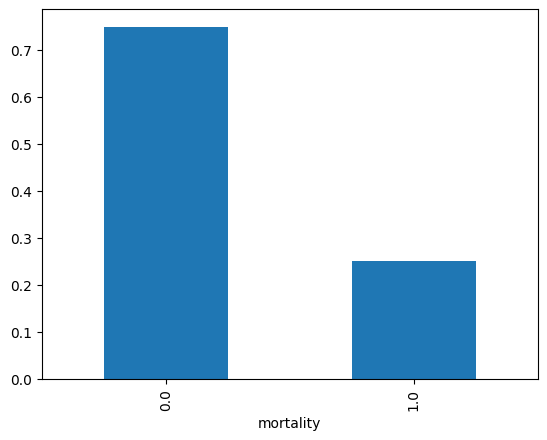

In [3]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [4]:
x = df.drop('mortality',axis=1)
y = df.mortality.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

In [5]:
#scaler = RobustScaler(unit_variance=True)
#scaler = QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

imp = KNNImputer(missing_values=np.nan, n_neighbors=10)#SimpleImputer(missing_values=np.nan, strategy='mean') #
x_train = imp.fit_transform(x_train)
x_test = imp.transform(x_test)

#smote = SMOTE(random_state = SEED)
#print('Original Dataset Shape:', np.unique(y_train, return_counts=True))
#x_train, y_train = smote.fit_resample(x_train, y_train)
#print('Resampled Dataset Shape:', np.unique(y_train, return_counts=True))
n_samples = x.shape[0]
_, (n_samples0, n_samples1) = np.unique(y, return_counts=True)
w0 =  n_samples/(2*n_samples0) #n_samples1/n_samples #
w1 =  n_samples/(2*n_samples1) #n_samples0/n_samples #
print(n_samples, n_samples0, n_samples1)
print(w0,w1)

5647 4232 1415
0.6671786389413988 1.9954063604240282


In [6]:
probit = probitModel(l2=0.05, w0=w0, w1=w1)
result, loss_values = probit.fit(x_train,y_train)
print("Optimized parameters (b):", result.x)

Current loss: 0.6688936844725587
Current loss: 0.6528217042494319
Current loss: 0.6484919242793068
Current loss: 0.6474014473959152
Current loss: 0.6470896320510625
Current loss: 0.6469706410210024
Current loss: 0.6469303135008136
Current loss: 0.6469062509720327
Current loss: 0.6469023707099038
Current loss: 0.646900836813903
Current loss: 0.6469004173683033
Current loss: 0.6469003212199718
Current loss: 0.6469002942398105
Current loss: 0.6469002795805092
Current loss: 0.646900275826386
Current loss: 0.6469002748123034
Optimized parameters (b): [ 1.11308367e-02  5.76210284e-02 -7.78712572e-02  4.01841764e-02
  9.42537307e-03  2.10988461e-02  5.63135258e-02  2.15199344e-02
  1.06260260e-01 -5.46847462e-03  7.58638590e-03  1.02209540e-02
 -6.50338470e-02 -2.26011872e-02 -9.25440514e-03 -5.34125798e-02
 -4.08719169e-02  4.28891136e-02 -2.00254560e-02 -3.11062082e-02
 -5.27882462e-05  1.23835925e-01 -5.35534800e-02  6.95826752e-03
 -9.11345630e-02 -8.12784795e-02  7.89160521e-03 -4.426150

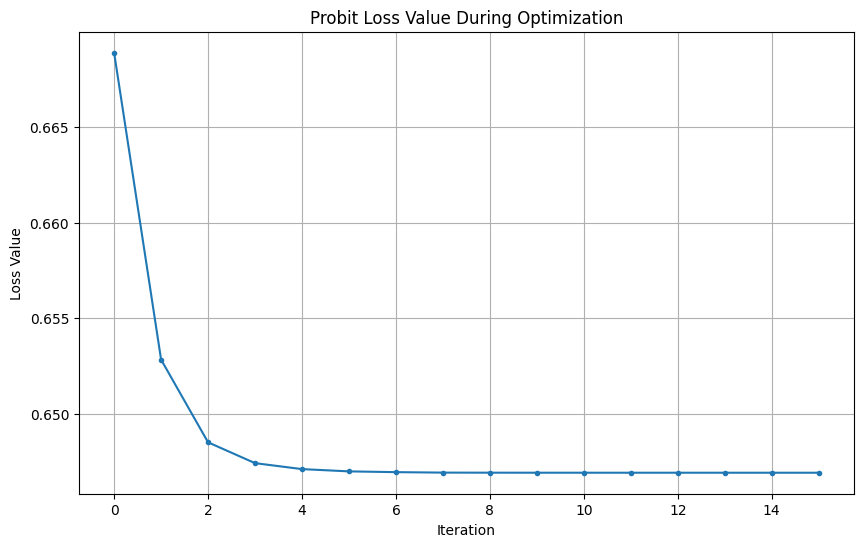

In [7]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

Accuracy: 0.648
Precision: 0.395
Recall: 0.595
F1 Score: 0.475
AUC score: 0.672 



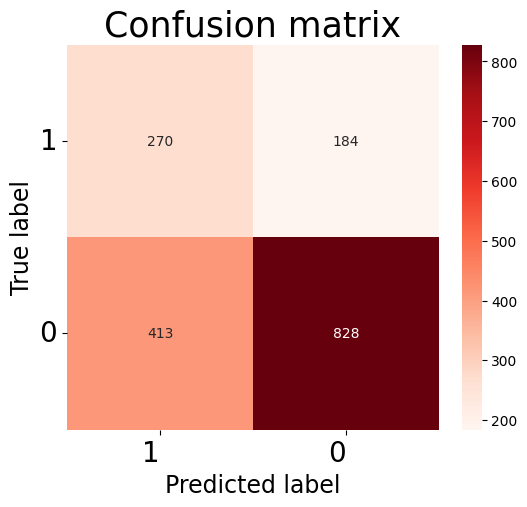

In [8]:
y_prob = probit.predict_proba(x_test)
y_label = probit.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

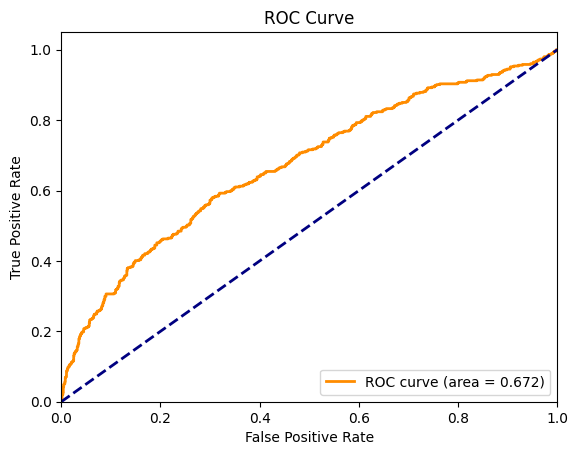

In [9]:
plot_roc(y_test, y_prob)

In [10]:
logit = logisticModel(l2=0.0, w0=w0, w1=w1)
result, loss_values = logit.fit(x_train,y_train)
print("Optimized parameters (b):", result.x)

Current loss: 0.6500046028620637
Current loss: 0.6400416348131095
Current loss: 0.6349286453222549
Current loss: 0.6317474785912836
Current loss: 0.629999125172218
Current loss: 0.6291280697511092
Current loss: 0.6286190780269526
Current loss: 0.6281939145967066
Current loss: 0.6277901169984994
Current loss: 0.6274558788657829
Current loss: 0.6271696440639093
Current loss: 0.6268679042614363
Current loss: 0.6265433419182481
Current loss: 0.6262567450486459
Current loss: 0.6260447954902106
Current loss: 0.6258814566394316
Current loss: 0.6257270907197552
Current loss: 0.625573994253712
Current loss: 0.6254524455130036
Current loss: 0.6253778983845472
Current loss: 0.6253341736810311
Current loss: 0.6253035401618379
Current loss: 0.6252773309666243
Current loss: 0.6252518059786789
Current loss: 0.6252255284038578
Current loss: 0.6251987195042729
Current loss: 0.6251734719139693
Current loss: 0.6251533230605308
Current loss: 0.6251405424410234
Current loss: 0.625133468835636
Current loss:

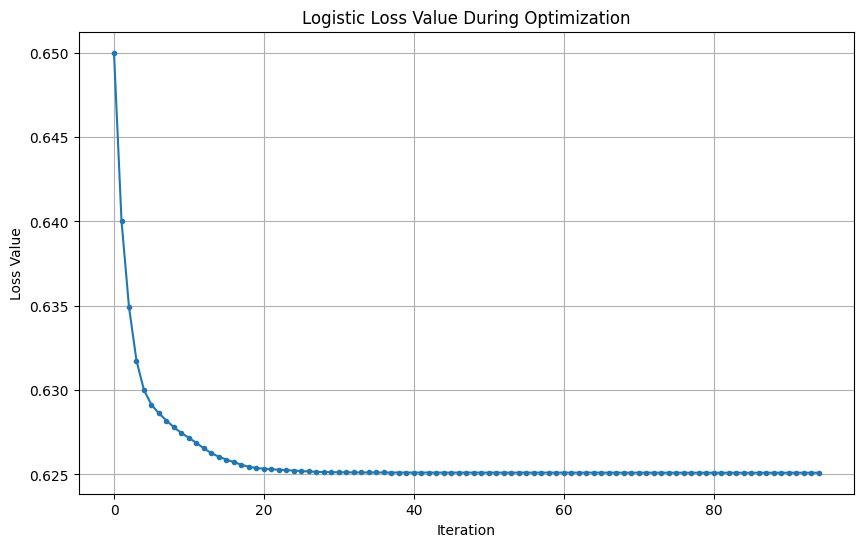

In [11]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

Accuracy: 0.653
Precision: 0.398
Recall: 0.579
F1 Score: 0.472
AUC score: 0.674 



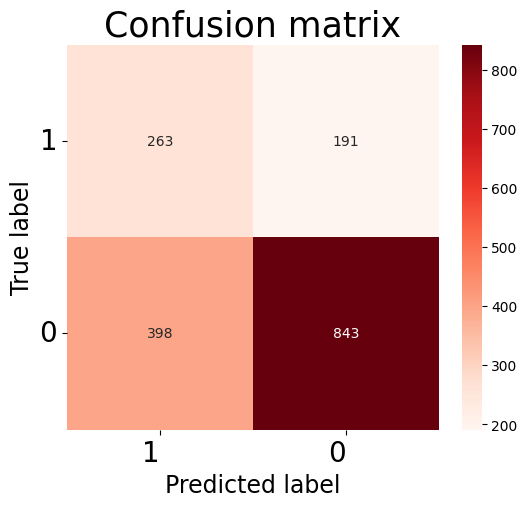

In [12]:
y_prob = logit.predict_proba(x_test)
y_label = logit.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

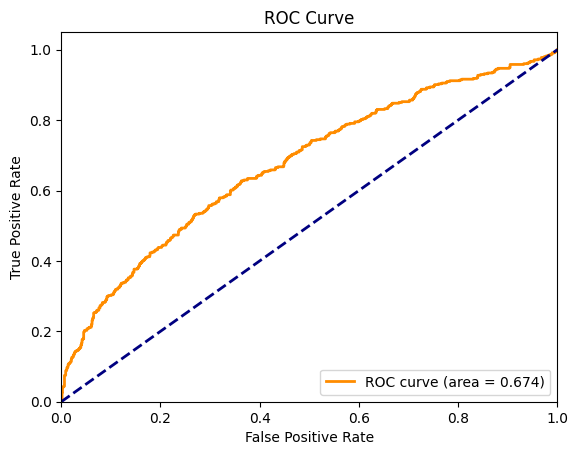

In [13]:
plot_roc(y_test, y_prob)

In [14]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(x_train, y_train)
b_sklearn = model.coef_[0]  # Weights (b)
bias_sklearn = model.intercept_[0]  # Bias term


In [15]:
from sklearn.metrics import log_loss

log_loss(y_test, model.predict_proba(x_test))

0.5450982238609953

Accuracy: 0.749
Precision: 0.667
Recall: 0.123
F1 Score: 0.208
AUC score: 0.676 



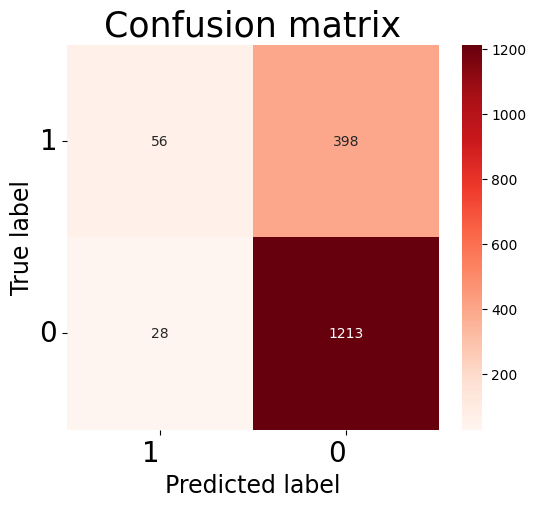

In [16]:
y_prob = model.predict_proba(x_test)[:,1]
y_label = model.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

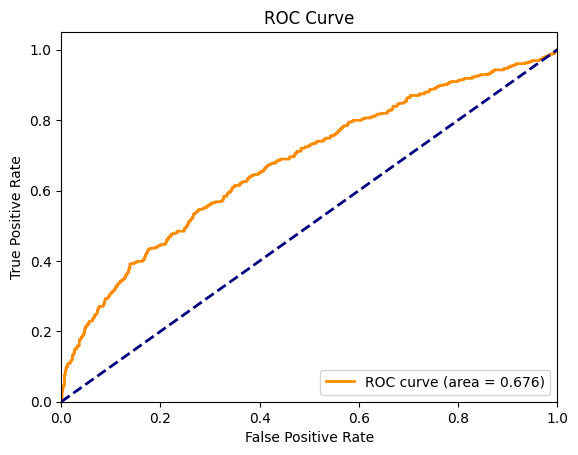

In [17]:
plot_roc(y_test, y_prob)